# GPU Convolution

This notebooks shows how to perform the same convolution from the previous notebooks using CUDA Toolkit.

![raw](./imgs/rari.jpg)

#### from previous notebooks

In [3]:
%reset -f

from PIL import Image
import ctypes
from ctypes import *
import numpy as np
import time

# http://localhost:8888/notebooks/1_Image_Metadata.ipynb
from AI_Decomposed import image_meta 
from AI_Decomposed import display_channel

# http://localhost:8888/notebooks/2_Py_Convolution.ipynb
from AI_Decomposed import PY_recurse_pooling

# http://localhost:8888/notebooks/3_CPP_Convolution.ipynb
from AI_Decomposed import native_recurse_pooling
cpp_function_ptr = cdll.LoadLibrary('./cpp/cmake-build-debug/libconvolution.so').recurse_convolution

## GPU programming with CUDA

### Quick CUDA Tutorial

![gpu code](imgs/cuda.png)

## our source code

http://localhost:8888/edit/gpu/simple_pooling.cu

## 'nvcc' - compile into shareable library

In [4]:
!nvcc                          \
--ptxas-options=-v             \
--compiler-options '-fPIC'     \
-o ./gpu/lib_pooling_gpu.so    \
--shared  ./gpu/simple_pooling.cu

ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function '_Z7poolingPiS_iii' for 'sm_30'
ptxas info    : Function properties for _Z7poolingPiS_iii
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 18 registers, 348 bytes cmem[0]


## Python pointer to GPU library

In [5]:
gpu_function_ptr = cdll.LoadLibrary('/home/will/cuda-workspace/simple_pooling/src/lib_gpu_pooling.so').pooling

### load image

In [6]:
image_file = './imgs/rari.jpg'
[height, width, red,green,blue] = image_meta(image_file)
channel_size = height * width

print('image height  : ', height)
print('image width   : ', width)
print('chanel size   : ', channel_size)
print('total pixels  : ', channel_size * 3) # 3 channels

image height  :  504
image width   :  940
chanel size   :  473760
total pixels  :  1421280


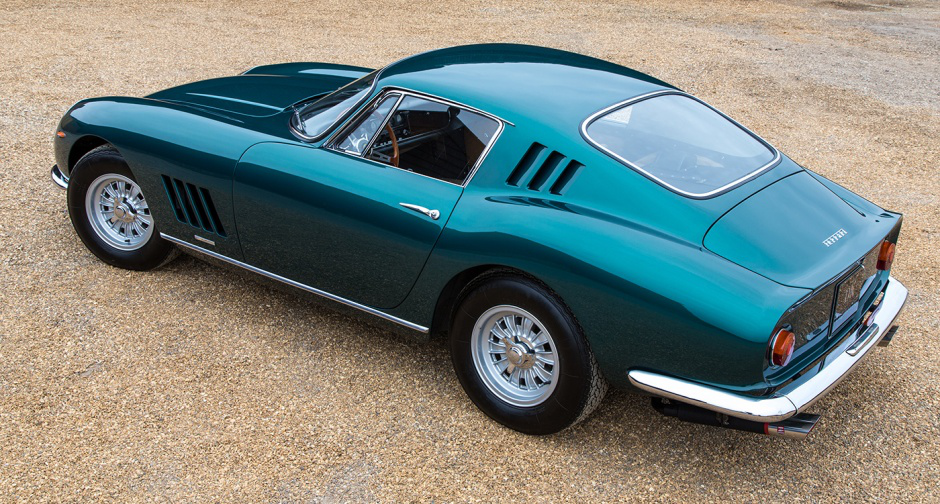

In [7]:
Image.open(image_file)

## baseline test

In [8]:
sample_mat = list(range(0,16,1))
display(sample_mat)
native_recurse_pooling(sample_mat, 4, 1, False, gpu_function_ptr)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

[2, 4, 4, 6, 8, 8, 10, 12, 12]

## image test

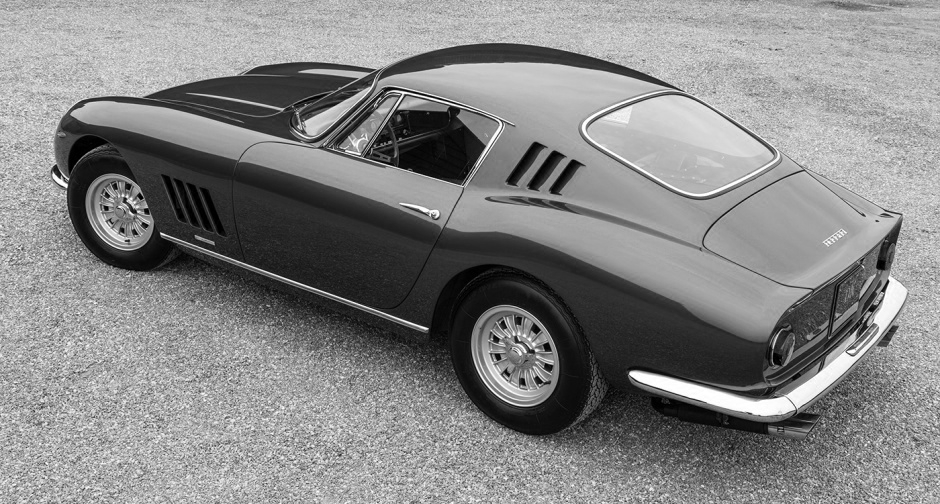

In [9]:
display_channel(green,width)

## parameters for recursioon and "mean pooling" instead of "max pooling"

In [10]:
recurse_cnt = 40
use_max = False

### green

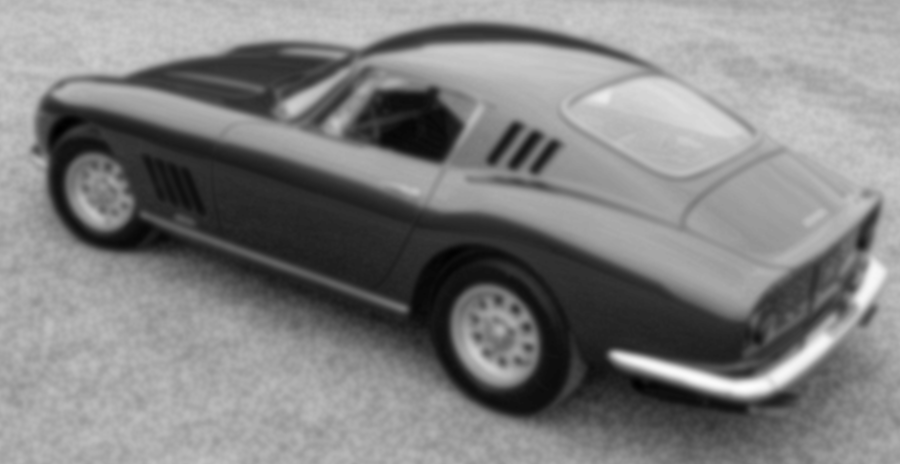

In [11]:
GPU_convolution = native_recurse_pooling( green, width, recurse_cnt, use_max, gpu_function_ptr )
display_channel ( GPU_convolution, width-recurse_cnt )

### blue

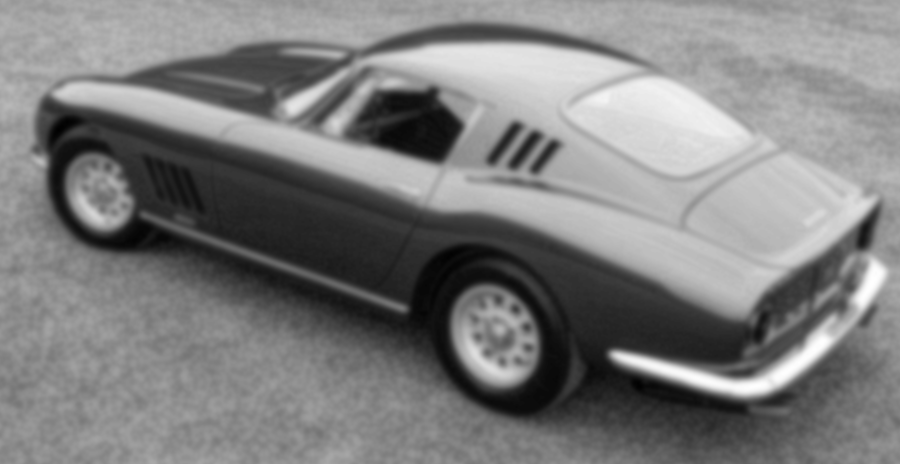

In [12]:
GPU_convolution = native_recurse_pooling( blue, width, recurse_cnt, use_max, gpu_function_ptr )
display_channel ( GPU_convolution, width-recurse_cnt )

### red

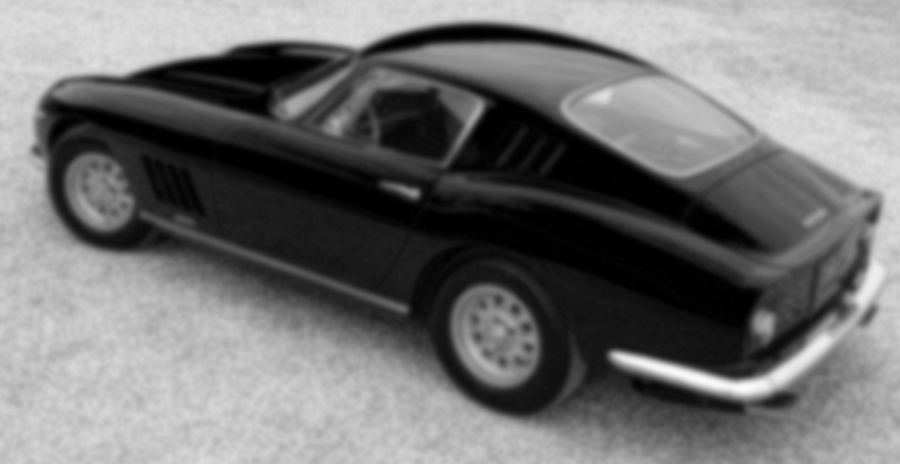

In [13]:
GPU_convolution = native_recurse_pooling( red, width, recurse_cnt, use_max, gpu_function_ptr )
display_channel ( GPU_convolution, width-recurse_cnt )

In [14]:
print('mat_size : ', len(green),'\n')
print('recurse_cnt,\tgpu_time,\tcpp_time')

for recurse_cnt in [1,10,100]:    
    
    print(recurse_cnt, end='', flush=True)
    print(',\t\t',   end='', flush=True)
    
    start = time.time()
    gpu_conv = native_recurse_pooling(green, width, recurse_cnt, False, gpu_function_ptr)    
    secs = round(time.time() - start,2)
    print(secs, end='', flush=True)
    print(',\t\t',   end='', flush=True)
    
    start = time.time()
    cpp_conv = native_recurse_pooling(green, width, recurse_cnt, False, cpp_function_ptr)    
    secs = round(time.time() - start,2)
    print(secs, end='', flush=True)
    print(',\t\t',   end='', flush=True)
    
    #start = time.time()
    #py_conv = PY_recurse_pooling(green, width, np.mean, recurse_cnt)    
    #secs = round(time.time() - start,2)
    #print(secs, end='', flush=True)
        
    print()        
        
print('\n\nfinished')            

mat_size :  473760 

recurse_cnt,	gpu_time,	cpp_time
1,		0.1,		0.21,		
10,		0.1,		1.23,		
100,		0.12,		11.67,		


finished


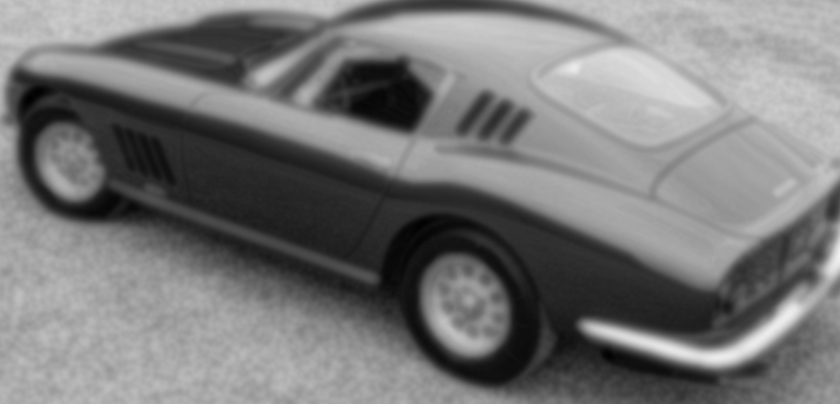

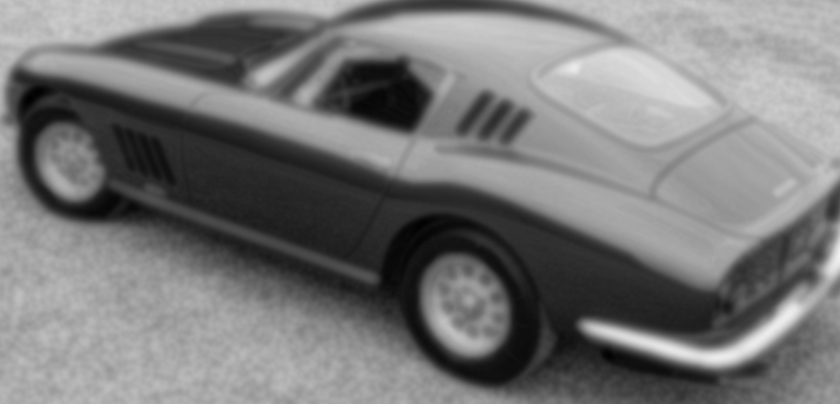

In [15]:
display_channel(gpu_conv, width - (recurse_cnt))
display_channel(cpp_conv, width - (recurse_cnt))     